LSE Data Science Institute | DS105A (2023/24) | Week 08

# 🗓️ Week 08: Pre-processing and grouping data with pandas, a groupby-apply tutorial

Theme: Cleaning and reshaping data

**LAST UPDATED:** 23 November 2023

**AUTHOR:** Dr [Jon Cardoso-Silva](https://jonjoncardoso.github.io)

-----


# **📚 PREPARATION**

1. Clone this repository to your computer.
2. Add it to your VS Code workspace.
3. Go to [IMDb Non-Commercial Datasets](https://developer.imdb.com/non-commercial-datasets/) page, and download all `tsv.gz` files from there, place all of that under the `data/raw/` folder. This folder is gitignored, we don't want to push large data files to GitHub!
4. Run:

    ```bash
    pip install -r requirements.txt
    ```

## ⚙️ Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from plotnine import *
from pprint import pprint
from tqdm.notebook import tqdm

# Configure some settings for high quality plots
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# Part 1: Read zipped files

You will have noticed that the files we downloaded from IMDb are compressed, which means they were transformed from **plain text** into a convenient **binary format** that uses less space. This is a good practice when handling large text-based files, making them easier to store and transfer. However, we _do_ need to read the files into memory, and for that, we need to decompress them.

**How to decompress files?**

- If you are on Windows, you can use software like [7-Zip](https://www.7-zip.org/). After installing it, right-click on the file and select "Extract here".
- If you are on Mac, you can use the built-in Archive Utility. Right-click on the file and select "Open with" > "Archive Utility". Or, simply double-click on the file.

**🐼 `pandas` for the rescue!**

Luckily, `pandas` has our back. It can read compressed files directly without the need to decompress them first. If you specify the `compression` argument, the `pd.read_csv()` function can read compressed files directly  <sup>\[[1](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)\]</sup>

If the file inside the compressed `.gz` file was a CSV, we could read it like this:

```python
pd.read_csv("../data/raw/name.basics.tsv.gz", compression="gzip").head()
```

However, note that the files we downloaded from IMDb are **TSV** files, not CSV. TSV stands for **Tab-Separated Values**, and it is a format similar to CSV, but instead of using commas to separate values, it uses tabs (`\t`). Why use TSV? Who knows. The developers thought it was a good idea, I guess. 

Anyway, since the format is still very similar to CSV, we can use the same function to read it, but we need to specify the `sep` argument to tell `pandas` that the separator is a tab (`\t`):

## 1.1: 👽 Establishing first contact with the data

In [ ]:
# This will take a bit of time, it is a large file
df_name_basics = pd.read_csv("../data/raw/name.basics.tsv.gz", compression="gzip", sep="\t")

🗣️ **QUESTION TO THE CLASSROOM:** What are the first things we should do when we read a new dataset, **whether** collected by you or from someone else?

<div style="color:#f8f8f8">

<details><summary>Click here to see some hidden tips</summary>

Open new code cells with the following code:

```python
# Glimpse at the data
df_name_basics.head()
```

```python
# Get a bit of info on the data types and memory usage
df_name_basics.info()
```

```bash
# How does the memory usage compare to the file size?
!ls -lth ../data/raw/
```
</summary>

</div>

In [ ]:
# Glimpse at the data
df_name_basics.head()

In [ ]:
# Get a bit of info on the data types and memory usage
df_name_basics.info()

In [ ]:
# How does the memory usage compare to the file size?
!ls -lth ../data/raw/

## 1.2 🗃️ Being your best perfectionist with data types

🎯 **ACTION POINTS:**

Work in groups (same composition as your group project) and do the following:

1. Disable GitHub Copilot, and don't use ChatGPT for now. Or it will make this less fun.

2. Modify the columns so that, in the end, they have the data types listed above. Try to deal with any errors that may arise.

3. Once you solved the errors, go to issue [#1](https://github.com/lse-ds105/w08-imdb-data/issues/1)(https://github.com/lse-ds105/w08-imdb-data/issues/1) that I created in this repository and add your group's solution. (add your group's name)


💡 Tips (if stuck):

- Look back at your W07 lab notebook to remember how to change data types.
- If you get an error, try to understand what it means.
- If you need to replace the contents of a column in pandas, you can use the `df["column_name"] = ...` syntax.

In [3]:
df_name_basics = pd.read_csv("../data/raw/name.basics.tsv.gz", 
                             compression="gzip", 
                             sep="\t",
                             na_values="\\N", 
                             nrows=100000)

In [4]:
df_name_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   nconst             100000 non-null  object 
 1   primaryName        100000 non-null  object 
 2   birthYear          31061 non-null   float64
 3   deathYear          15756 non-null   float64
 4   primaryProfession  97816 non-null   object 
 5   knownForTitles     99092 non-null   object 
dtypes: float64(2), object(4)
memory usage: 4.6+ MB


In [ ]:
df_name_basics.describe()

In [5]:
df_name_basics["deathYear"] = df_name_basics["deathYear"].astype('Int16')
df_name_basics["birthYear"] = df_name_basics["birthYear"].astype('Int16')

# Part 2: 📊 Exploring the data

(This is also an 🎯 **ACTION POINT**)

Let's pose a few questions to the data:

**Q1:** Summarise: how many people recorded in this dataset are alive, and how many are dead?

In [6]:
df_name_basics['is_alive'] = df_name_basics['deathYear'].isna()
df_name_basics['is_alive'].value_counts()

is_alive
True     84244
False    15756
Name: count, dtype: int64

In case you enjoy practising some f-strings:

In [ ]:
print(f"Answer: {df_name_basics['is_alive'].value_counts()[True]} people are presumed alive")
print(f"Answer: {df_name_basics['is_alive'].value_counts()[False]} people are dead")

**Q2:** Focusing on those who are dead, calculate their `age_at_death` (in years) as a separate column. Then, plot a histogram of the ages at death. What is the most common age at death?

In [7]:
df_name_basics['age_at_death'] = df_name_basics['deathYear'] - df_name_basics['birthYear']

valid_rows = df_name_basics['is_alive'] == False

plot_df = df_name_basics[valid_rows]

# Investigate problems with the data
plot_df['age_at_death'].describe()


count      15341.0
mean     72.316472
std      14.949704
min            0.0
25%           63.0
50%           74.0
75%           84.0
max          112.0
Name: age_at_death, dtype: Float64

I doubt that anyone lived to be 1000+ years old, and I also doubt that anyone died before they were born. Let's filter out those rows:

In [ ]:
# Redefine valid_rows
valid_rows = (df_name_basics['is_alive'] == False) & (df_name_basics['age_at_death'] > 0) & (df_name_basics['age_at_death'] < 150)

# Redefine plot_df
plot_df = df_name_basics[valid_rows]

In [ ]:
p = (
    ggplot(plot_df, aes(x='age_at_death')) +
    geom_histogram(binwidth=5, fill='blue', color='black', alpha=0.7) +
    labs(title='Histogram of Ages at Death', x='Age at Death', y='Frequency') +
    theme_minimal() + 
    theme(figure_size=(11, 6))
)

p

**Q3:** How many primary professions does each person have? Plot a bar chart of the number of professions per person.

In [20]:
df_name_basics['primaryProfession'] = df_name_basics['primaryProfession'].astype(str)

In [18]:
def split_professions(professions_list):
    return professions_list.split(',')

In [29]:
df_name_basics['num_professions'] = df_name_basics['primaryProfession'].apply(split_professions).apply(len)

In [31]:
df_name_basics['num_professions'].value_counts()

num_professions
1    57319
3    26209
2    16472
Name: count, dtype: int64

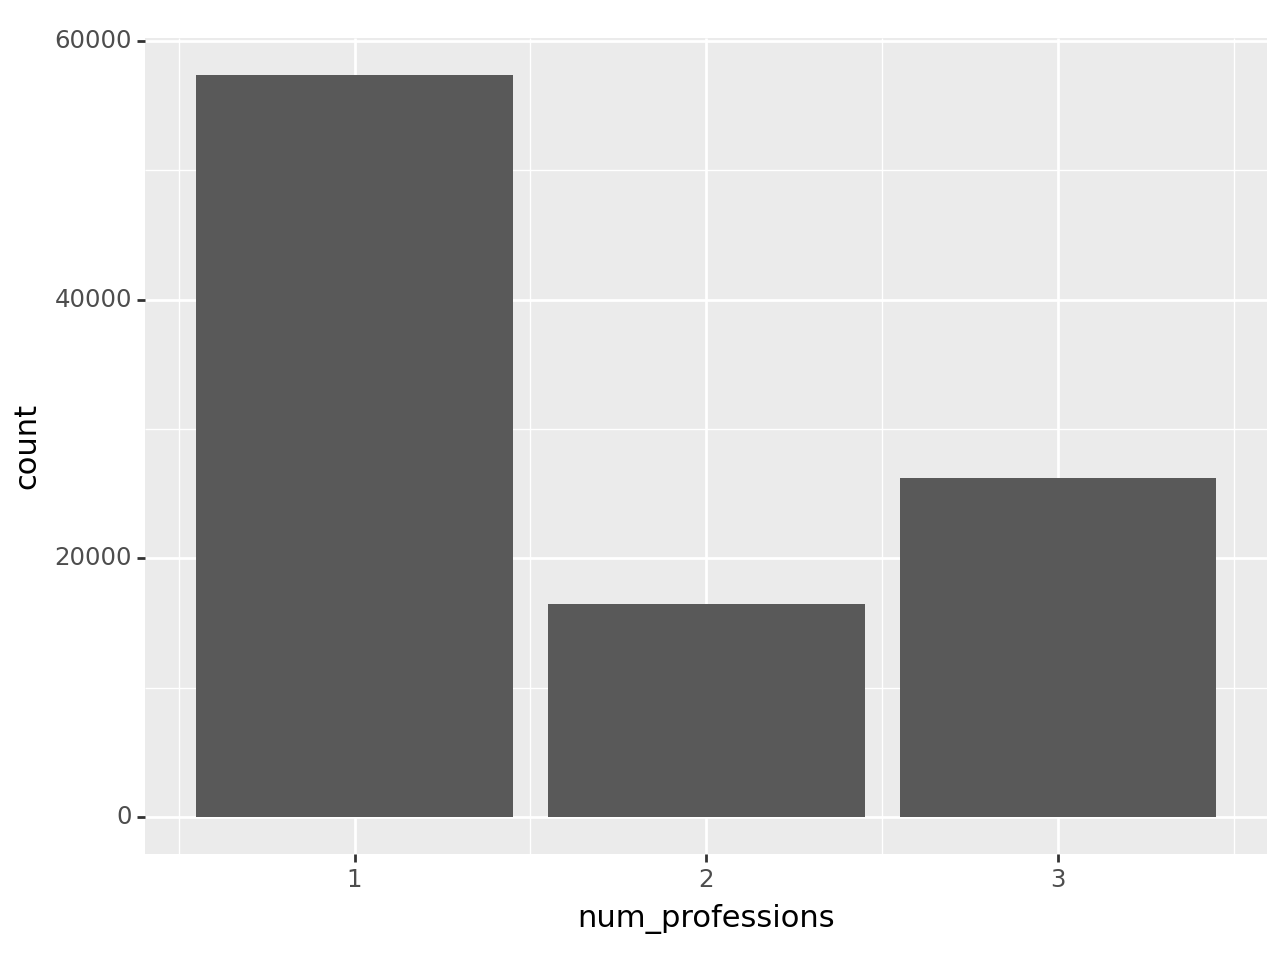

<Figure Size: (640 x 480)>

In [32]:
plot_df = df_name_basics[['num_professions']]

g = (
    ggplot(plot_df, aes(x='num_professions')) + 
    geom_bar()

)

g

In [42]:
# group-by -> apply

plot_df = df_name_basics.groupby(['num_professions']).apply(len).reset_index()
plot_df.columns = ['num_professions', 'count']
plot_df

,num_professions,count
0,1,57319
1,2,16472
2,3,26209


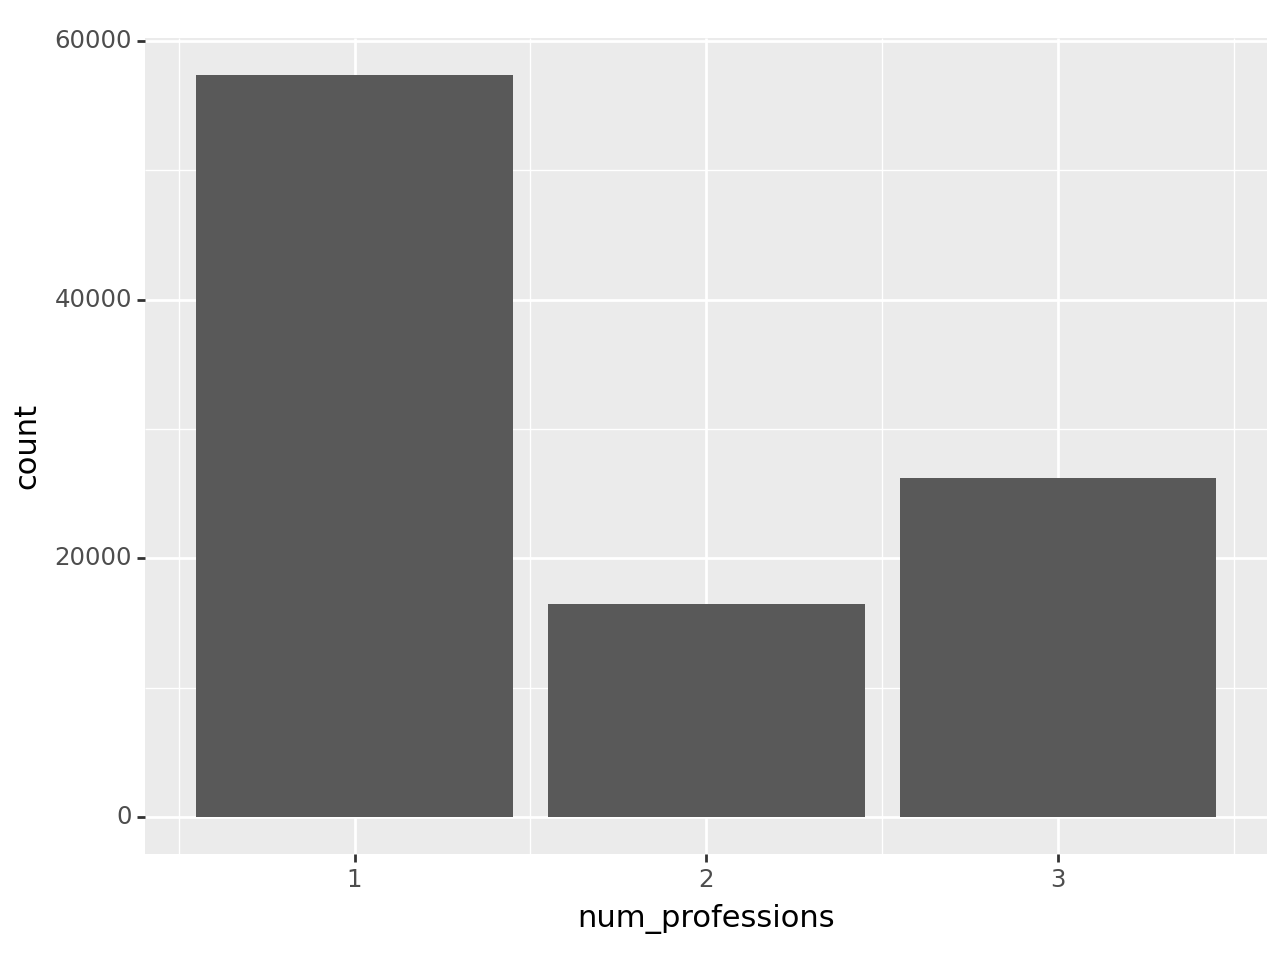

<Figure Size: (640 x 480)>

In [43]:
g = (
    ggplot(plot_df, aes(x='num_professions', y='count')) + 
    geom_col()

)

g

**Q4:** Did those with acting roles die younger or older than those with other roles?

In [ ]:
# Your answer here

# Part 3: 🔃 Data from multiple sources

(This is also an 🎯 **ACTION POINT**)

This time, you are asked to complement `df_name_basics` from the IMDb dataset with data from another dataset, `df_title_basics`, which contains information about the titles in which each person has participated.


**Step 1:** Add a dict column to the `df_name_basics` indicating the genres of the titles in which each person has participated. The dict should have the following format:

```python
{
    "genre_1": count_of_titles_in_genre_1,
    "genre_2": count_of_titles_in_genre_2,
    ...
}
```

**Q5:** Focusing on just **movies**, what is the average age of actors in their first movie? What is the average age of actors during their last recorded movie?